<h1 style="text-align: center;">Analyis of Point Production of NBA Players</h1>

# Introduction

Using this dataset of NBA player stats we want to perform a regression analysis of the variables that measure a players overall preformance on court, including assists, rebounds, points, and net rating. To do so, all non-preformance related stats, including, age,  height, weight, draft pick, and country will be used. The season variable will also allow player preformances to be measured throughout time and compare NBA starts from all eras and styles of the game from 1996 onwards. All of these things are factors that where better numbers in each category may contribute to a more successful player.

Our question: How do our selected factors help to predict the individual performance of NBA players? 

To do this, we will use [this dataset](https://www.kaggle.com/datasets/justinas/nba-players-data) from Kaggle. The data was acquired through the NBA API with missing information supplied by scraping from another NBA source (for this reason, the dataset was taken directly from Kaggle and not the original source). 

# Data Analysis

## Load Libraries

In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Load Dataset

First we load in the Data Set of interest.

In [11]:
url <-"https://raw.githubusercontent.com/mdean808/dsci-100-group-project/b11c50b091b2c4a554a2b7ff8f9e568e081b0f3c/all_seasons.csv"


temp <- tempfile()


download.file(url, temp)
# read the dataset from temp file
nba_players <- read_csv(temp)
head(nba_players)

New names:
• `` -> `...1`
Rows: 12305 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): player_name, team_abbreviation, college, country, draft_year, draf...
dbl (14): ...1, age, player_height, player_weight, gp, pts, reb, ast, net_ra...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,⋯,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,Dennis Rodman,CHI,36,198.12,99.79024,Southeastern Oklahoma State,USA,1986,2,⋯,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28,215.90,117.93392,Florida,USA,1990,1,⋯,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39,205.74,95.25432,Detroit Mercy,USA,1979,3,⋯,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24,203.20,100.69742,UCLA,USA,1995,1,⋯,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34,205.74,108.86208,Villanova,USA,1985,1,⋯,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97
5,Eddie Johnson,HOU,38,200.66,97.52228,Illinois,USA,1981,2,⋯,8.2,2.7,1.0,4.1,0.034,0.126,0.220,0.541,0.102,1996-97


For our project, we will focus only on the specific parameters to judge the overall performance of an NBA player.

In [12]:
nba_players <- nba_players |>
filter(draft_year > 2000) |>
select(age, player_height, player_weight, pts, reb, ts_pct)
nba_players

age,player_height,player_weight,pts,reb,ts_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,195.58,87.99685,5.0,1.7,0.565
23,190.50,95.25432,10.6,3.2,0.510
32,200.66,97.52228,6.4,2.3,0.521
⋮,⋮,⋮,⋮,⋮,⋮
28,193.04,99.79024,12.1,3.8,0.540
23,195.58,92.98636,1.1,1.9,0.280
24,208.28,112.49082,4.0,3.0,0.505


Now, we will split the data into training and testing. We will use the training data to build our regression model and our testing data to test the validity of our model. 

In [14]:
nba_players_split <- initial_split(nba_players, prop = 0.75, strata = pts)
nba_training <- training(nba_players_split)
nba_testing <- testing(nba_players_split)

nba_training

age,player_height,player_weight,pts,reb,ts_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
27,190.50,92.98636,1.0,0.0,0.258
27,193.04,83.91452,2.4,0.8,0.422
28,177.80,72.57472,2.2,0.4,0.479
⋮,⋮,⋮,⋮,⋮,⋮
23,190.50,97.52228,17.2,4.2,0.541
32,203.20,98.88306,15.4,4.4,0.549
28,193.04,99.79024,12.1,3.8,0.540


Now we will look at the correlation of multiple paramters compared with pts. This will allow us to predict which parameters strongly influence overall points scored before we build our regression model. 

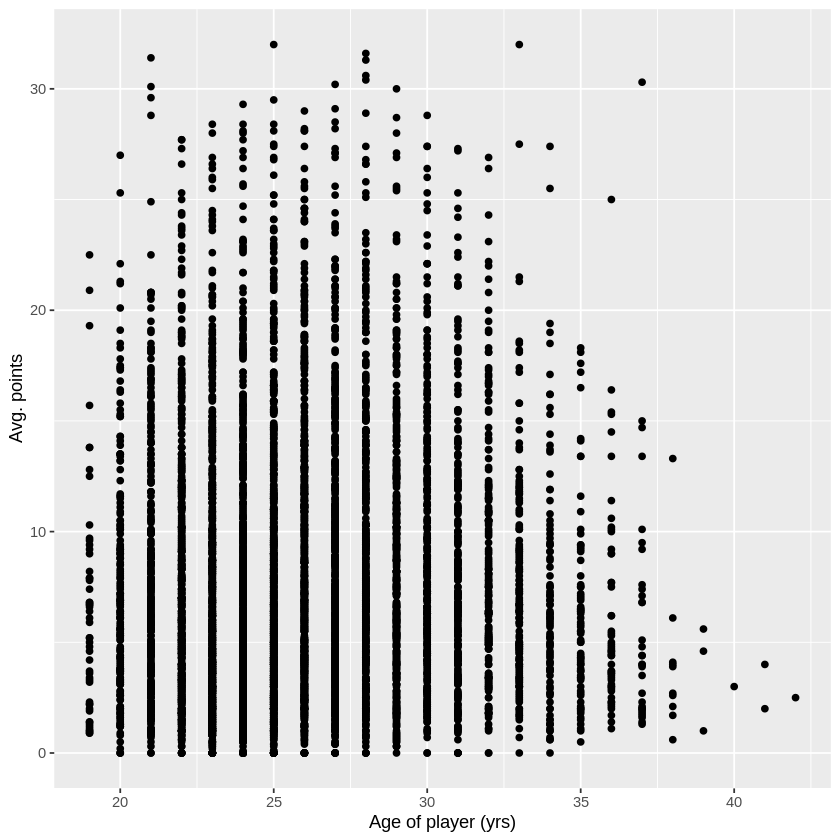

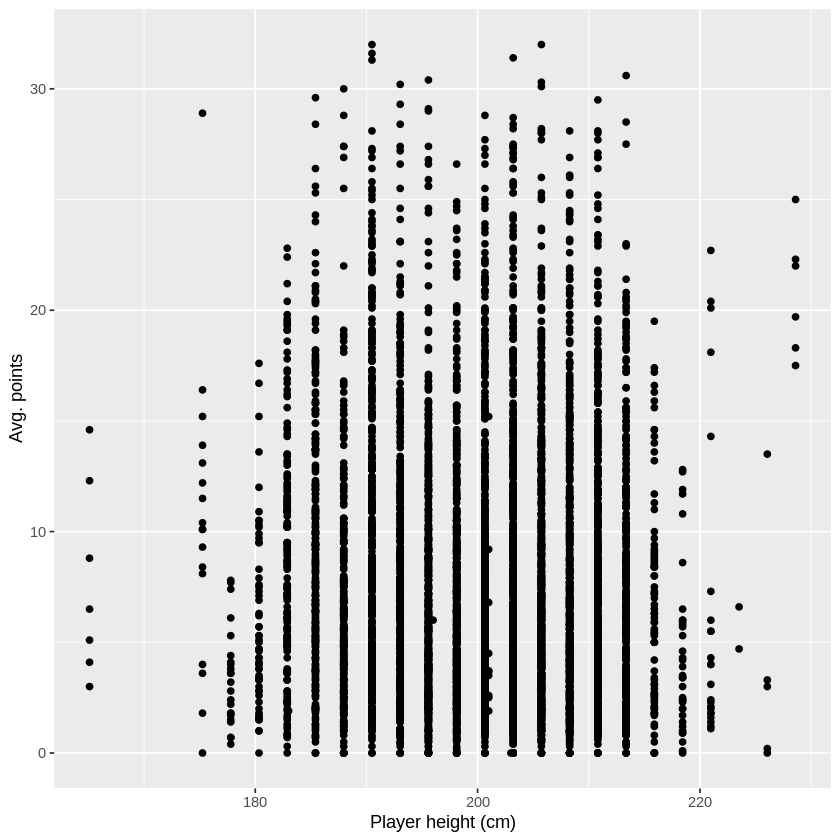

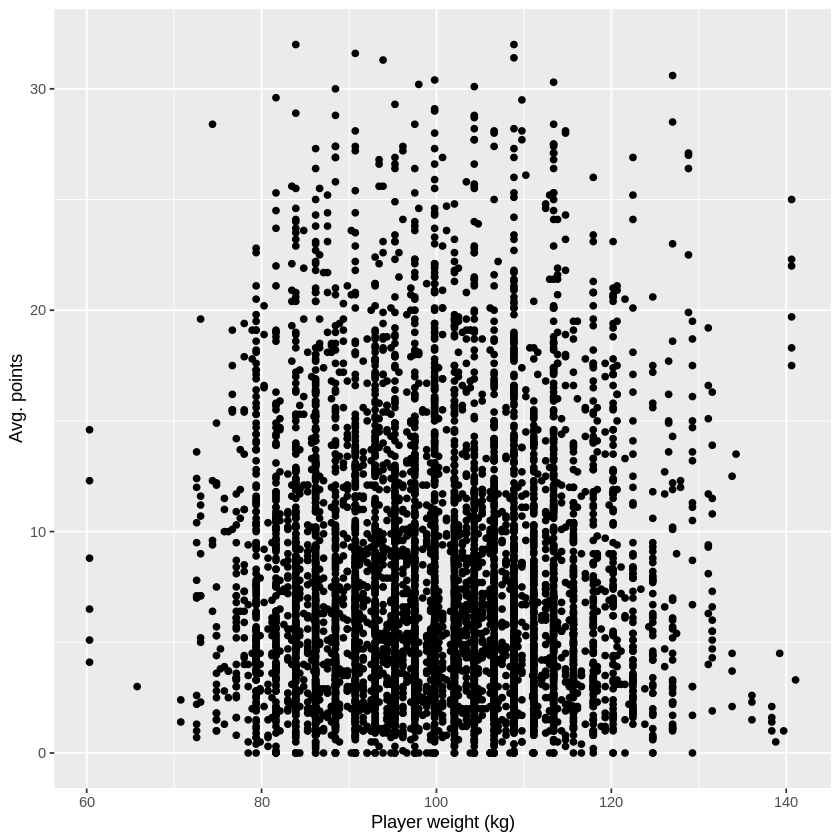

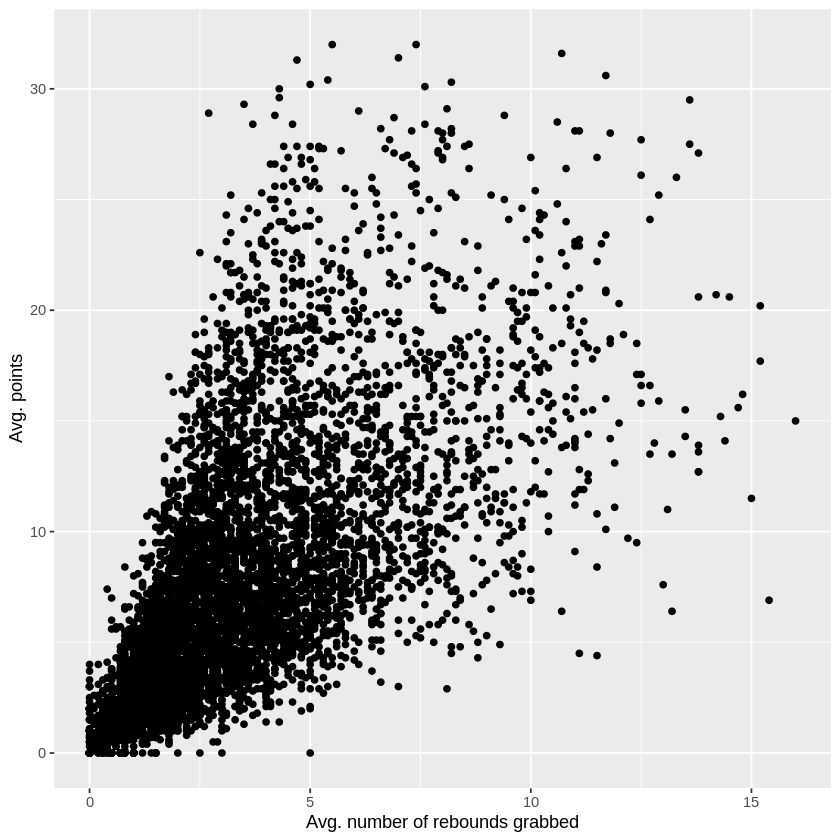

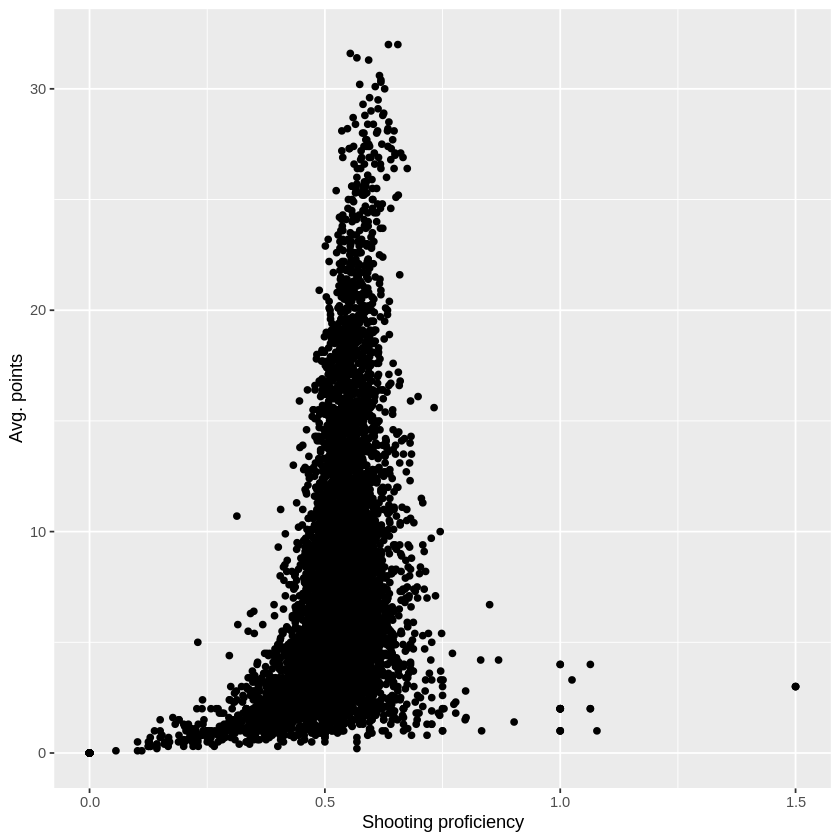

In [15]:
nba_plot_age <- ggplot(nba_training, aes(x = age, y = pts)) +
geom_point() +
labs(x = "Age of player (yrs)", y = "Avg. points")

nba_plot_height <- ggplot(nba_training, aes(x = player_height, y = pts)) +
geom_point() +
labs(x = "Player height (cm)", y = "Avg. points")

nba_plot_weight <- ggplot(nba_training, aes(x = player_weight, y = pts)) +
geom_point() +
labs(x = "Player weight (kg)", y = "Avg. points")

nba_plot_reb <- ggplot(nba_training, aes(x = reb, y = pts)) +
geom_point() +
labs(x = "Avg. number of rebounds grabbed", y = "Avg. points")

nba_plot_ts_pct <- ggplot(nba_training, aes(x = ts_pct, y = pts)) +
geom_point() +
labs(x = "Shooting proficiency", y = "Avg. points")

nba_plot_age
nba_plot_height
nba_plot_weight
nba_plot_reb
nba_plot_ts_pct 

As shown in the graphs, shooting profiency and and average number of rebounds grabbed have a strong positive correlation with average points. We expect these two parameters to be good predictors for performance.

# Methods

The original dataset contained 22 variables, the majority of which were discarded as being impractical to use due to having little impact on player performance (player name) or being directly related to another variable. We will conduct analysis on five columns to try and predict the average points a player will get per season using regression analysis. 

We will visualize the results using a scatter plots that contains a line of best fit and datapoints for each category compared to the actual points result. By first training a model on the training data for each respective datapoint category we will then analyze the regression and decide which of the columns is most effective at indicating points production.

# Expected Outcomes and Signifigance

We expect to find that age and draft pick will point to greater points production. We do think weight and height will have an effect on production, but not perhaps to the same extent as the other datapoints.

These findings could be useful for improving a player's training routine. If a certain factor like an increase in shooting or rebounds increased their overall points total we could suggest that a player change the way they train for an upcoming season.

This could lead to feature questions about aspects of team performance. Does one player's excellence transfer over to a team's overall production? 